In [28]:
import torchvision
import torchvision.transforms as transforms
import numpy as np
import torch

data_dir = r"M:\UNIVERSIDAD 2025_2\INTELIGENCIA ATRIFICIAL\CUADERNILLOS\archive"

transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor()
])

dataset = torchvision.datasets.ImageFolder(root=data_dir, transform=transform)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
trainset, testset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_images = np.array([np.array(img.permute(1, 2, 0)) for img, label in trainset])
X_test = np.array([np.array(img.permute(1, 2, 0)) for img, label in testset])

train_labels = np.array([label for img, label in trainset])
y_test = np.array([label for img, label in testset])

X_train, X_val, X_subset = train_images, X_test, train_images[:5000]
y_train, y_val, y_subset = train_labels, y_test, train_labels[:5000]

classes = dataset.classes
print("Clases:", classes)
print("Train:", len(trainset), "Test:", len(testset))

Clases: ['paper', 'rock', 'scissors']
Train: 1750 Test: 438


In [29]:
import torch

class Dataset(torch.utils.data.Dataset):
    def __init__(self, X, Y):
        self.X = torch.from_numpy(X / 255.).float().view(-1, 32*32*3)
        self.Y = torch.from_numpy(Y).long()
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, ix):
        return self.X[ix], self.Y[ix]

dataset = {
    'train': Dataset(X_subset, y_subset),
    'val': Dataset(X_val, y_val),
}

dataloader = {
    'train': torch.utils.data.DataLoader(dataset['train'], batch_size=32, shuffle=True),
    'val': torch.utils.data.DataLoader(dataset['val'], batch_size=1000, shuffle=False)
}

len(dataset['train']), len(dataset['val'])

(1750, 438)

In [30]:
from sklearn.metrics import accuracy_score

def softmax(x):
    return torch.exp(x) / torch.exp(x).sum(axis=-1,keepdims=True)

def build_model(D_in=32*32*3, H=256, D_out=3):
    return torch.nn.Sequential(
        torch.nn.Linear(D_in, H),
        torch.nn.ReLU(),
        torch.nn.Dropout(0.3),
        torch.nn.Linear(H, H//2),
        torch.nn.ReLU(),
        torch.nn.Dropout(0.2),
        torch.nn.Linear(H//2, D_out)
    )

def fit(model, dataloader, optimizer, epochs=100, log_each=10, weight_decay=0, early_stopping=0):
    criterion = torch.nn.CrossEntropyLoss()
    l, acc = [], []
    val_l, val_acc = [], []
    best_acc, step = 0, 0
    
    for e in range(1, epochs+1):
        _l, _acc = [], []
        model.train()
        
        for x_b, y_b in dataloader['train']:
            y_pred = model(x_b)
            loss = criterion(y_pred, y_b)
            _l.append(loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            y_probas = torch.argmax(softmax(y_pred), axis=1)
            _acc.append(accuracy_score(y_b.cpu().numpy(), y_probas.cpu().detach().numpy()))
        
        l.append(np.mean(_l))
        acc.append(np.mean(_acc))
        
        model.eval()
        _l, _acc = [], []
        with torch.no_grad():
            for x_b, y_b in dataloader['val']:
                y_pred = model(x_b)
                loss = criterion(y_pred, y_b)
                _l.append(loss.item())
                y_probas = torch.argmax(softmax(y_pred), axis=1)
                _acc.append(accuracy_score(y_b.cpu().numpy(), y_probas.cpu().numpy()))
        
        val_l.append(np.mean(_l))
        val_acc.append(np.mean(_acc))
        
        if val_acc[-1] > best_acc:
            best_acc = val_acc[-1]
            torch.save(model.state_dict(), 'ckpt.pt')
            step = 0
            print(f"Mejor modelo guardado con acc {best_acc:.5f} en epoch {e}")
        step += 1
        
        if early_stopping and step > early_stopping:
            print(f"Entrenamiento detenido en epoch {e} por no mejorar en {early_stopping} epochs seguidas")
            break
            
        if not e % log_each:
            print(f"Epoch {e}/{epochs} loss {l[-1]:.5f} acc {acc[-1]:.5f} val_loss {val_l[-1]:.5f} val_acc {val_acc[-1]:.5f}")
    
    model.load_state_dict(torch.load('ckpt.pt'))
    return {'epoch': list(range(1, len(l)+1)), 'loss': l, 'acc': acc, 'val_loss': val_l, 'val_acc': val_acc}

In [33]:
model = build_model()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
hist_sgd = fit(model, dataloader, optimizer, epochs=150)

Mejor modelo guardado con acc 0.34247 en epoch 1
Epoch 10/150 loss 1.09980 acc 0.32975 val_loss 1.09982 val_acc 0.34247
Epoch 20/150 loss 1.09957 acc 0.31921 val_loss 1.09931 val_acc 0.34247
Epoch 30/150 loss 1.09887 acc 0.33388 val_loss 1.09898 val_acc 0.34247
Epoch 40/150 loss 1.09883 acc 0.32144 val_loss 1.09876 val_acc 0.34247
Epoch 50/150 loss 1.09839 acc 0.35604 val_loss 1.09862 val_acc 0.34247
Mejor modelo guardado con acc 0.42009 en epoch 53
Epoch 60/150 loss 1.09859 acc 0.34582 val_loss 1.09852 val_acc 0.34475
Epoch 70/150 loss 1.09862 acc 0.33704 val_loss 1.09845 val_acc 0.34475
Epoch 80/150 loss 1.09820 acc 0.33616 val_loss 1.09841 val_acc 0.34475
Epoch 90/150 loss 1.09834 acc 0.34101 val_loss 1.09838 val_acc 0.34475
Epoch 100/150 loss 1.09846 acc 0.34277 val_loss 1.09836 val_acc 0.34475
Epoch 110/150 loss 1.09867 acc 0.34019 val_loss 1.09834 val_acc 0.34475
Epoch 120/150 loss 1.09846 acc 0.34298 val_loss 1.09833 val_acc 0.34475
Epoch 130/150 loss 1.09853 acc 0.34184 val_los

In [47]:
model = build_model()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.99)
hist_momentum = fit(model, dataloader, optimizer)

Mejor modelo guardado con acc 0.34475 en epoch 1
Epoch 10/100 loss 1.09849 acc 0.34189 val_loss 1.09828 val_acc 0.34475
Epoch 20/100 loss 1.09868 acc 0.34230 val_loss 1.09890 val_acc 0.34475
Epoch 30/100 loss 1.09887 acc 0.34163 val_loss 1.09854 val_acc 0.34475
Epoch 40/100 loss 1.09862 acc 0.33957 val_loss 1.09851 val_acc 0.34475
Epoch 50/100 loss 1.09842 acc 0.34267 val_loss 1.09815 val_acc 0.34475
Epoch 60/100 loss 1.09847 acc 0.33084 val_loss 1.09843 val_acc 0.34475
Epoch 70/100 loss 1.09868 acc 0.34390 val_loss 1.09873 val_acc 0.34475
Epoch 80/100 loss 1.09846 acc 0.34132 val_loss 1.09860 val_acc 0.34475
Mejor modelo guardado con acc 0.35616 en epoch 83
Epoch 90/100 loss 1.09856 acc 0.34375 val_loss 1.09780 val_acc 0.34475
Epoch 100/100 loss 1.09841 acc 0.34473 val_loss 1.09818 val_acc 0.34475


In [14]:
model = build_model()
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001)
hist_rms = fit(model, dataloader, optimizer)

Mejor modelo guardado con acc 0.34703 en epoch 1
Mejor modelo guardado con acc 0.55936 en epoch 2
Mejor modelo guardado con acc 0.58676 en epoch 3
Mejor modelo guardado con acc 0.73059 en epoch 4
Mejor modelo guardado con acc 0.77169 en epoch 5
Mejor modelo guardado con acc 0.82877 en epoch 8
Epoch 10/100 loss 0.57906 acc 0.78998 val_loss 0.55238 val_acc 0.82648
Mejor modelo guardado con acc 0.83333 en epoch 12
Mejor modelo guardado con acc 0.83790 en epoch 13
Mejor modelo guardado con acc 0.84475 en epoch 15
Mejor modelo guardado con acc 0.84932 en epoch 17
Mejor modelo guardado con acc 0.86758 en epoch 18
Epoch 20/100 loss 0.40742 acc 0.86854 val_loss 0.41546 val_acc 0.85160
Mejor modelo guardado con acc 0.87671 en epoch 23
Mejor modelo guardado con acc 0.88356 en epoch 27
Mejor modelo guardado con acc 0.89041 en epoch 28
Epoch 30/100 loss 0.27632 acc 0.90883 val_loss 0.30039 val_acc 0.88128
Mejor modelo guardado con acc 0.89726 en epoch 31
Mejor modelo guardado con acc 0.91324 en ep

In [17]:
model = build_model()
optimizer = torch.optim.Adam(model.parameters(), lr=0.003)
hist_adam = fit(model, dataloader, optimizer)

Mejor modelo guardado con acc 0.29909 en epoch 1
Mejor modelo guardado con acc 0.65068 en epoch 2
Mejor modelo guardado con acc 0.81050 en epoch 3
Mejor modelo guardado con acc 0.83333 en epoch 5
Mejor modelo guardado con acc 0.86301 en epoch 9
Mejor modelo guardado con acc 0.86758 en epoch 10
Epoch 10/100 loss 0.40055 acc 0.86038 val_loss 0.39248 val_acc 0.86758
Mejor modelo guardado con acc 0.86986 en epoch 13
Mejor modelo guardado con acc 0.88356 en epoch 15
Mejor modelo guardado con acc 0.89954 en epoch 16
Mejor modelo guardado con acc 0.91324 en epoch 17
Epoch 20/100 loss 0.23611 acc 0.92190 val_loss 0.24568 val_acc 0.90411
Mejor modelo guardado con acc 0.91781 en epoch 23
Mejor modelo guardado con acc 0.92694 en epoch 24
Mejor modelo guardado con acc 0.92922 en epoch 27
Mejor modelo guardado con acc 0.93836 en epoch 29
Epoch 30/100 loss 0.15408 acc 0.94551 val_loss 0.19607 val_acc 0.93607
Mejor modelo guardado con acc 0.94064 en epoch 36
Mejor modelo guardado con acc 0.94521 en e

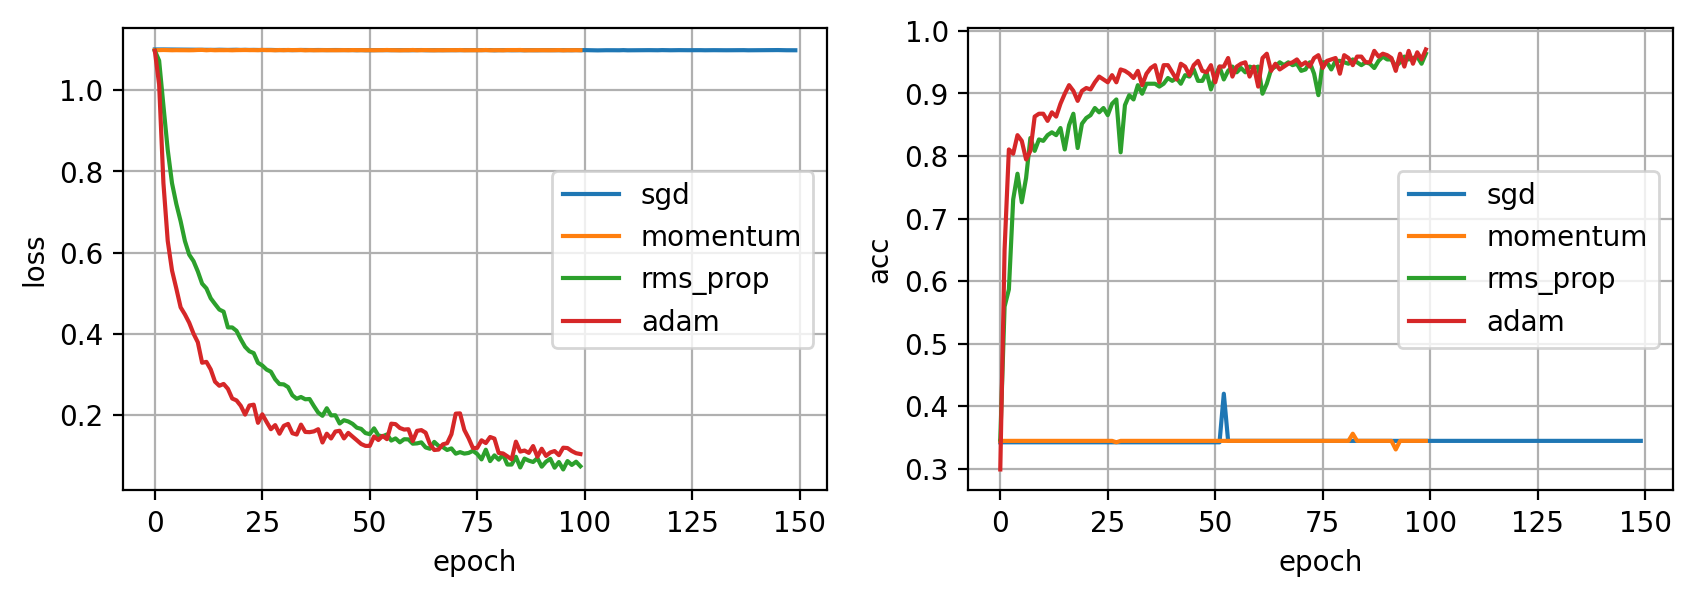

In [48]:
import matplotlib.pyplot as plt

fig = plt.figure(dpi=200, figsize=(10,3))

ax = plt.subplot(121)
ax.plot(hist_sgd['loss'], label="sgd")
ax.plot(hist_momentum['loss'], label="momentum")
ax.plot(hist_rms['loss'], label="rms_prop")
ax.plot(hist_adam['loss'], label="adam")
ax.legend()
ax.grid(True)
ax.set_xlabel('epoch')
ax.set_ylabel('loss')

ax = plt.subplot(122)
ax.plot(hist_sgd['val_acc'], label="sgd")
ax.plot(hist_momentum['val_acc'], label="momentum")
ax.plot(hist_rms['val_acc'], label="rms_prop")
ax.plot(hist_adam['val_acc'], label="adam")
ax.legend()
ax.grid(True)
ax.set_ylabel('acc')
ax.set_xlabel('epoch')
plt.show()

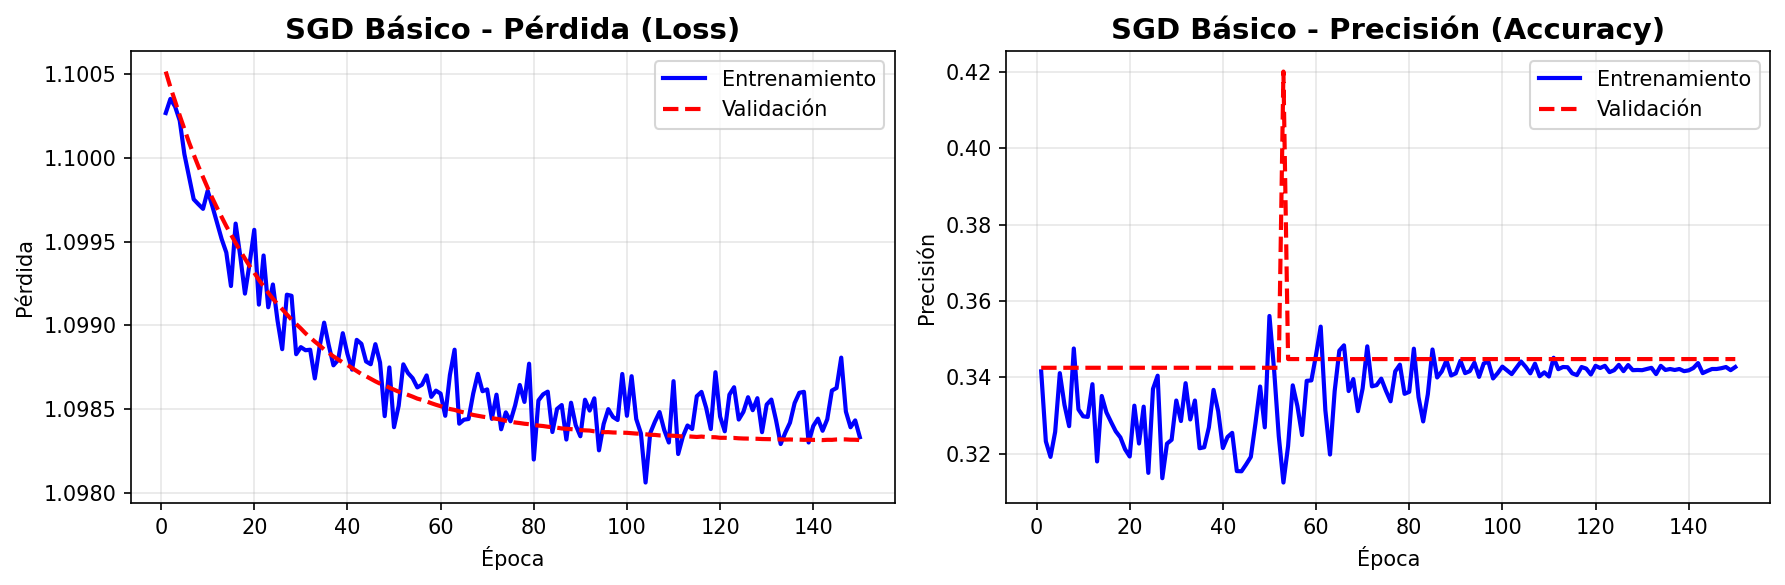

SGD Básico - Precisión final: 34.47%
SGD Básico - Mejor precisión alcanzada: 42.01%
SGD Básico - Épocas entrenadas: 150


In [35]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4), dpi=150)

ax1.plot(hist_sgd['epoch'], hist_sgd['loss'], 'b-', linewidth=2, label='Entrenamiento')
ax1.plot(hist_sgd['epoch'], hist_sgd['val_loss'], 'r--', linewidth=2, label='Validación')
ax1.set_title('SGD Básico - Pérdida (Loss)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Época')
ax1.set_ylabel('Pérdida')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.plot(hist_sgd['epoch'], hist_sgd['acc'], 'b-', linewidth=2, label='Entrenamiento')
ax2.plot(hist_sgd['epoch'], hist_sgd['val_acc'], 'r--', linewidth=2, label='Validación')
ax2.set_title('SGD Básico - Precisión (Accuracy)', fontsize=14, fontweight='bold')
ax2.set_xlabel('Época')
ax2.set_ylabel('Precisión')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

final_acc = hist_sgd['val_acc'][-1]
best_acc = max(hist_sgd['val_acc'])
print(f"SGD Básico - Precisión final: {final_acc:.2%}")
print(f"SGD Básico - Mejor precisión alcanzada: {best_acc:.2%}")
print(f"SGD Básico - Épocas entrenadas: {len(hist_sgd['epoch'])}")

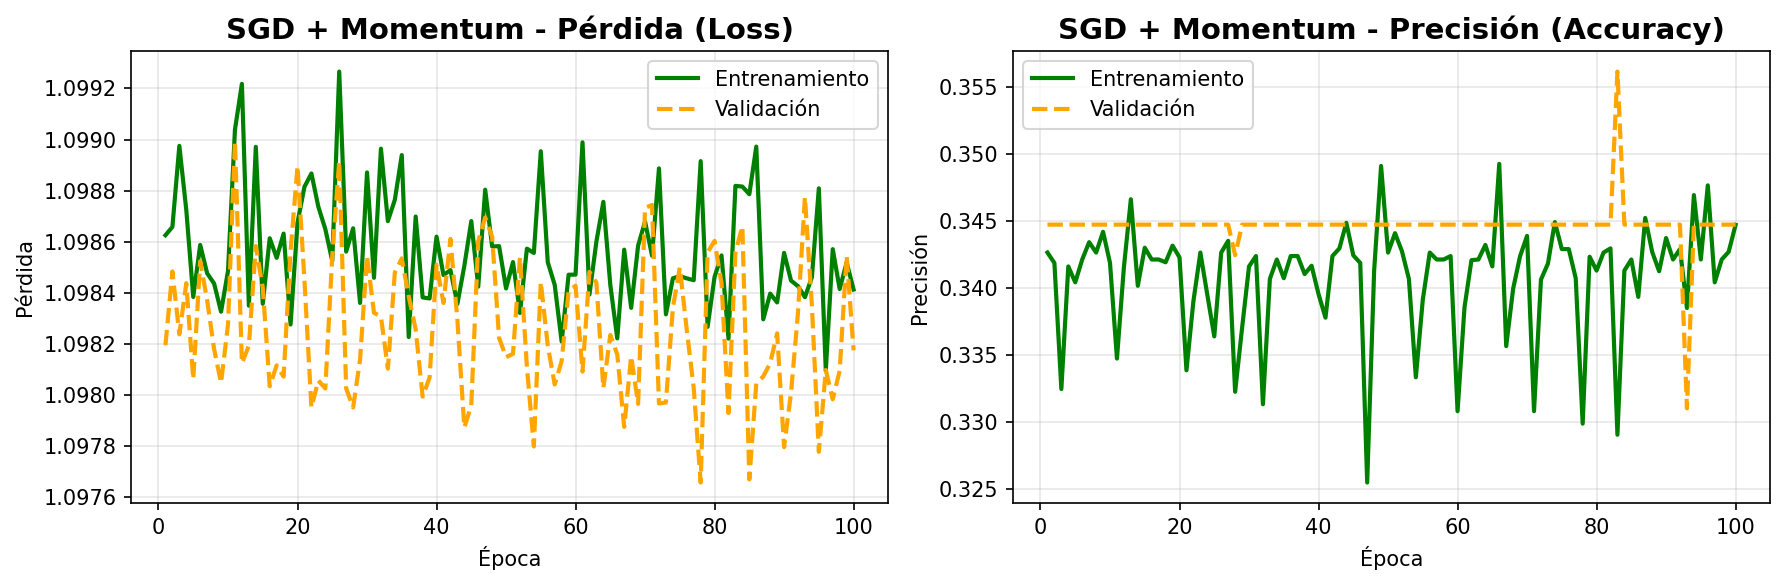

SGD + Momentum - Precisión final: 34.47%
SGD + Momentum - Mejor precisión alcanzada: 35.62%
SGD + Momentum - Épocas entrenadas: 100


In [49]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4), dpi=150)

ax1.plot(hist_momentum['epoch'], hist_momentum['loss'], 'g-', linewidth=2, label='Entrenamiento')
ax1.plot(hist_momentum['epoch'], hist_momentum['val_loss'], 'orange', linestyle='--', linewidth=2, label='Validación')
ax1.set_title('SGD + Momentum - Pérdida (Loss)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Época')
ax1.set_ylabel('Pérdida')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.plot(hist_momentum['epoch'], hist_momentum['acc'], 'g-', linewidth=2, label='Entrenamiento')
ax2.plot(hist_momentum['epoch'], hist_momentum['val_acc'], 'orange', linestyle='--', linewidth=2, label='Validación')
ax2.set_title('SGD + Momentum - Precisión (Accuracy)', fontsize=14, fontweight='bold')
ax2.set_xlabel('Época')
ax2.set_ylabel('Precisión')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

final_acc = hist_momentum['val_acc'][-1]
best_acc = max(hist_momentum['val_acc'])
print(f"SGD + Momentum - Precisión final: {final_acc:.2%}")
print(f"SGD + Momentum - Mejor precisión alcanzada: {best_acc:.2%}")
print(f"SGD + Momentum - Épocas entrenadas: {len(hist_momentum['epoch'])}")

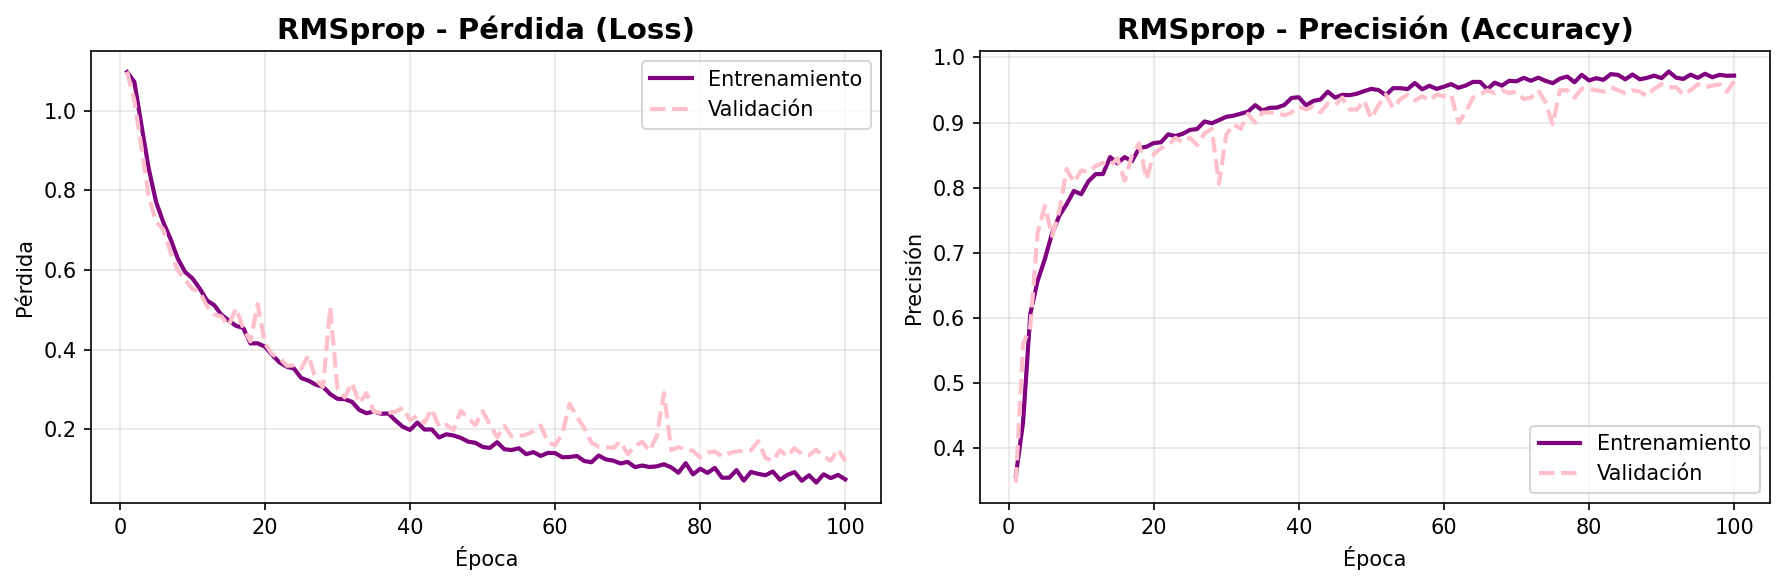

RMSprop - Precisión final: 96.35%
RMSprop - Mejor precisión alcanzada: 96.35%
RMSprop - Épocas entrenadas: 100


In [23]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4), dpi=150)

ax1.plot(hist_rms['epoch'], hist_rms['loss'], 'purple', linewidth=2, label='Entrenamiento')
ax1.plot(hist_rms['epoch'], hist_rms['val_loss'], 'pink', linestyle='--', linewidth=2, label='Validación')
ax1.set_title('RMSprop - Pérdida (Loss)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Época')
ax1.set_ylabel('Pérdida')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.plot(hist_rms['epoch'], hist_rms['acc'], 'purple', linewidth=2, label='Entrenamiento')
ax2.plot(hist_rms['epoch'], hist_rms['val_acc'], 'pink', linestyle='--', linewidth=2, label='Validación')
ax2.set_title('RMSprop - Precisión (Accuracy)', fontsize=14, fontweight='bold')
ax2.set_xlabel('Época')
ax2.set_ylabel('Precisión')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

final_acc = hist_rms['val_acc'][-1]
best_acc = max(hist_rms['val_acc'])
print(f"RMSprop - Precisión final: {final_acc:.2%}")
print(f"RMSprop - Mejor precisión alcanzada: {best_acc:.2%}")
print(f"RMSprop - Épocas entrenadas: {len(hist_rms['epoch'])}")

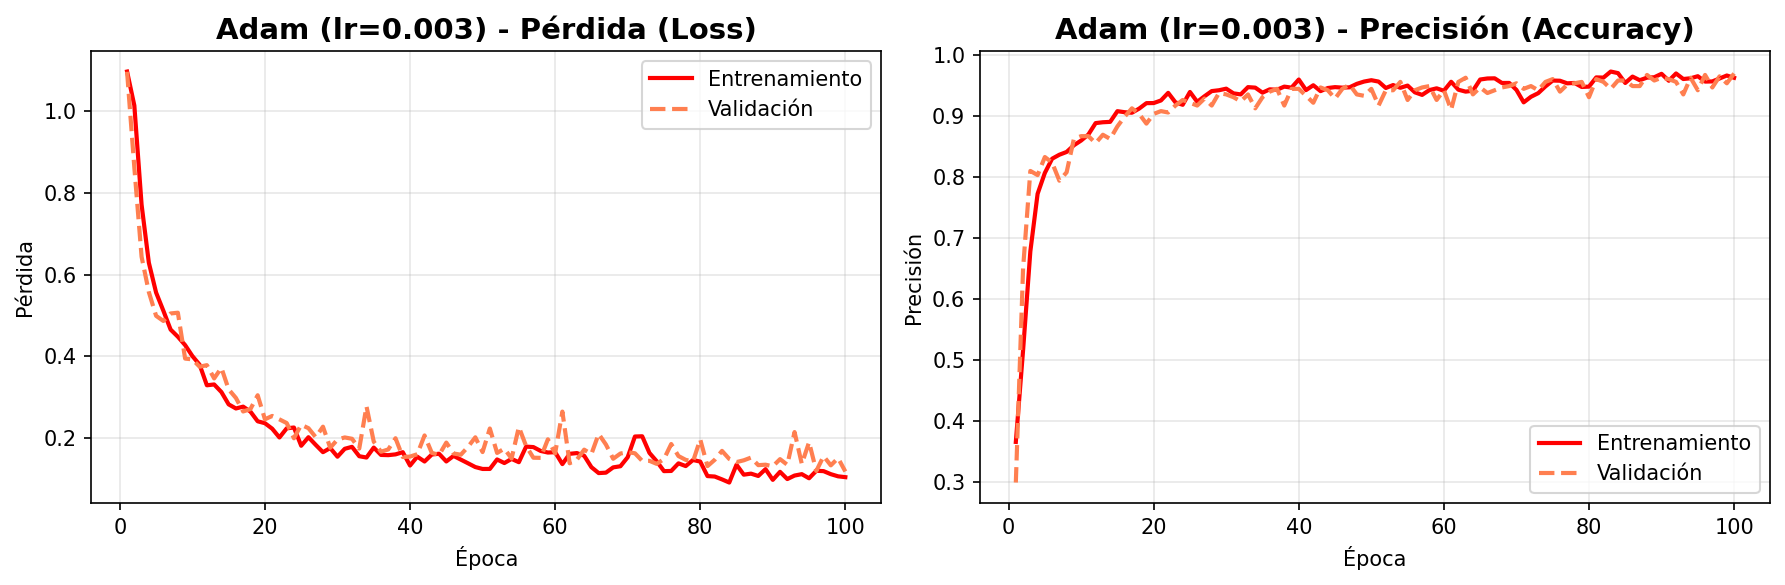

Adam (mejorado) - Precisión final: 97.03%
Adam (mejorado) - Mejor precisión alcanzada: 97.03%
Adam (mejorado) - Épocas entrenadas: 100


In [24]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4), dpi=150)

ax1.plot(hist_adam['epoch'], hist_adam['loss'], 'red', linewidth=2, label='Entrenamiento')
ax1.plot(hist_adam['epoch'], hist_adam['val_loss'], 'coral', linestyle='--', linewidth=2, label='Validación')
ax1.set_title('Adam (lr=0.003) - Pérdida (Loss)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Época')
ax1.set_ylabel('Pérdida')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.plot(hist_adam['epoch'], hist_adam['acc'], 'red', linewidth=2, label='Entrenamiento')
ax2.plot(hist_adam['epoch'], hist_adam['val_acc'], 'coral', linestyle='--', linewidth=2, label='Validación')
ax2.set_title('Adam (lr=0.003) - Precisión (Accuracy)', fontsize=14, fontweight='bold')
ax2.set_xlabel('Época')
ax2.set_ylabel('Precisión')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

final_acc = hist_adam['val_acc'][-1]
best_acc = max(hist_adam['val_acc'])
print(f"Adam (mejorado) - Precisión final: {final_acc:.2%}")
print(f"Adam (mejorado) - Mejor precisión alcanzada: {best_acc:.2%}")
print(f"Adam (mejorado) - Épocas entrenadas: {len(hist_adam['epoch'])}")

In [13]:
def fit(model, dataloader, optimizer, scheduler=None, epochs=100, log_each=10, weight_decay=0, early_stopping=0):
    criterion = torch.nn.CrossEntropyLoss()
    l, acc, lr = [], [], []
    val_l, val_acc = [], []
    best_acc, step = 0, 0
    
    for e in range(1, epochs+1):
        _l, _acc = [], []
        
        for param_group in optimizer.param_groups:
            lr.append(param_group['lr'])
            
        model.train()
        
        for x_b, y_b in dataloader['train']:
            y_pred = model(x_b)
            loss = criterion(y_pred, y_b)
            _l.append(loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            y_probas = torch.argmax(softmax(y_pred), axis=1)
            _acc.append(accuracy_score(y_b.cpu().numpy(), y_probas.cpu().detach().numpy()))
        
        l.append(np.mean(_l))
        acc.append(np.mean(_acc))
        
        model.eval()
        _l, _acc = [], []
        with torch.no_grad():
            for x_b, y_b in dataloader['val']:
                y_pred = model(x_b)
                loss = criterion(y_pred, y_b)
                _l.append(loss.item())
                y_probas = torch.argmax(softmax(y_pred), axis=1)
                _acc.append(accuracy_score(y_b.cpu().numpy(), y_probas.cpu().numpy()))
        
        val_l.append(np.mean(_l))
        val_acc.append(np.mean(_acc))
        
        if val_acc[-1] > best_acc:
            best_acc = val_acc[-1]
            torch.save(model.state_dict(), 'ckpt.pt')
            step = 0
            print(f"Mejor modelo guardado con acc {best_acc:.5f} en epoch {e}")
        step += 1
        
        if scheduler:
            scheduler.step()
        
        if early_stopping and step > early_stopping:
            print(f"Entrenamiento detenido en epoch {e} por no mejorar en {early_stopping} epochs seguidas")
            break
            
        if not e % log_each:
            print(f"Epoch {e}/{epochs} loss {l[-1]:.5f} acc {acc[-1]:.5f} val_loss {val_l[-1]:.5f} val_acc {val_acc[-1]:.5f} lr {lr[-1]:.5f}")
    
    model.load_state_dict(torch.load('ckpt.pt'))
    return {'epoch': list(range(1, len(l)+1)), 'loss': l, 'acc': acc, 'val_loss': val_l, 'val_acc': val_acc, 'lr': lr}

In [14]:
model = build_model()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 10, 0.1)

hist_step = fit(model, dataloader, optimizer, scheduler, epochs=30)

Mejor modelo guardado con acc 0.34247 en epoch 1
Epoch 10/30 loss 1.09957 acc 0.33223 val_loss 1.09809 val_acc 0.34247 lr 0.01000
Epoch 20/30 loss 1.09841 acc 0.34272 val_loss 1.09932 val_acc 0.34247 lr 0.00100
Epoch 30/30 loss 1.09858 acc 0.34220 val_loss 1.09937 val_acc 0.34247 lr 0.00010


In [15]:
model = build_model()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.0001, max_lr=0.01, step_size_up=5, step_size_down=25)

hist_cycle = fit(model, dataloader, optimizer, scheduler, epochs=30)

Mejor modelo guardado con acc 0.29224 en epoch 1
Mejor modelo guardado con acc 0.34247 en epoch 3
Epoch 10/30 loss 1.09889 acc 0.34241 val_loss 1.10013 val_acc 0.34247 lr 0.00842
Epoch 20/30 loss 1.09849 acc 0.33368 val_loss 1.09951 val_acc 0.34247 lr 0.00446
Epoch 30/30 loss 1.09851 acc 0.34236 val_loss 1.09950 val_acc 0.34247 lr 0.00050


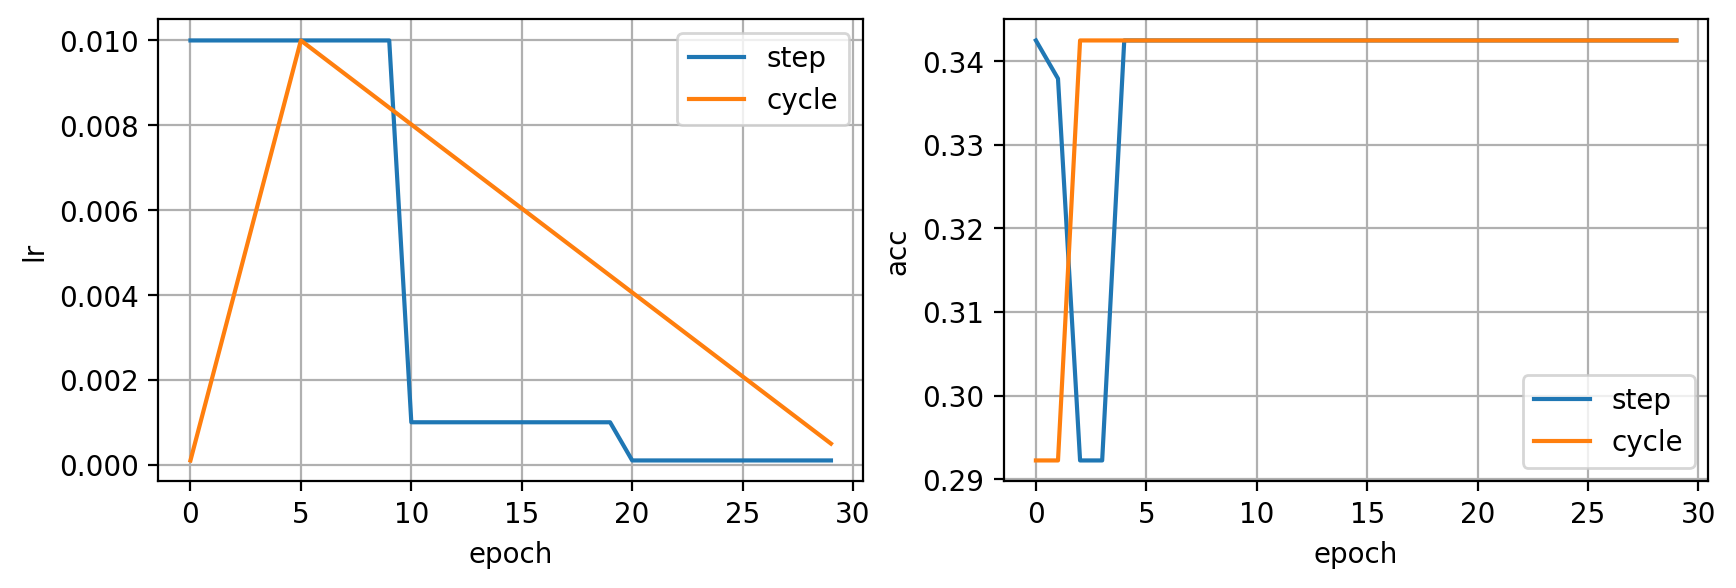


RESULTADOS DE SCHEDULERS:

StepLR - Precisión final: 34.25%
StepLR - Mejor precisión alcanzada: 34.25%
StepLR - Épocas entrenadas: 30

CyclicLR - Precisión final: 34.25%
CyclicLR - Mejor precisión alcanzada: 34.25%
CyclicLR - Épocas entrenadas: 30

Mejor resultado: CyclicLR


In [16]:
fig = plt.figure(dpi=200, figsize=(10,3))

ax = plt.subplot(121)
ax.plot(hist_step['lr'], label="step")
ax.plot(hist_cycle['lr'], label="cycle")
ax.legend()
ax.grid(True)
ax.set_xlabel('epoch')
ax.set_ylabel('lr')

ax = plt.subplot(122)
ax.plot(hist_step['val_acc'], label="step")
ax.plot(hist_cycle['val_acc'], label="cycle")
ax.legend()
ax.grid(True)
ax.set_ylabel('acc')
ax.set_xlabel('epoch')
plt.show()

print("\nRESULTADOS DE SCHEDULERS:")
print()

final_acc_step = hist_step['val_acc'][-1]
best_acc_step = max(hist_step['val_acc'])
epochs_step = len(hist_step['epoch'])
print(f"StepLR - Precisión final: {final_acc_step:.2%}")
print(f"StepLR - Mejor precisión alcanzada: {best_acc_step:.2%}")
print(f"StepLR - Épocas entrenadas: {epochs_step}")

print()

final_acc_cycle = hist_cycle['val_acc'][-1]
best_acc_cycle = max(hist_cycle['val_acc'])
epochs_cycle = len(hist_cycle['epoch'])
print(f"CyclicLR - Precisión final: {final_acc_cycle:.2%}")
print(f"CyclicLR - Mejor precisión alcanzada: {best_acc_cycle:.2%}")
print(f"CyclicLR - Épocas entrenadas: {epochs_cycle}")

print(f"\nMejor resultado: {'StepLR' if best_acc_step > best_acc_cycle else 'CyclicLR'}")

In [17]:
import numpy as np

mean = (train_images / 255).mean(axis=(0, 1, 2))

std = (train_images / 255).std(axis=(0, 1, 2))

mean, std

(array([0.00127163, 0.00215909, 0.00102511], dtype=float32),
 array([0.00098167, 0.0003771 , 0.00050082], dtype=float32))

In [18]:
train_images_norm = ((train_images / 255) - mean) / std

train_images_norm.mean(axis=(0, 1, 2)), train_images_norm.std(axis=(0, 1, 2))

(array([-0.00104607, -0.00566394, -0.00077258], dtype=float32),
 array([0.99853283, 1.00119   , 1.000763  ], dtype=float32))

In [19]:
X_test_norm = np.array([ (np.array(img)/255. - mean[:,None,None]) / std[:,None,None] for img, label in testset ])

X_train_norm = train_images_norm
X_val_norm = X_test_norm
X_subset_norm = train_images_norm[:5000]

print(f"Formas de los conjuntos normalizados:")
print(f"X_train_norm: {X_train_norm.shape}")
print(f"X_val_norm: {X_val_norm.shape}")
print(f"X_test_norm: {X_test_norm.shape}")
print(f"X_subset_norm: {X_subset_norm.shape}")
X_train_norm.shape, X_val_norm.shape, X_test_norm.shape, X_subset_norm.shape

Formas de los conjuntos normalizados:
X_train_norm: (1750, 32, 32, 3)
X_val_norm: (438, 3, 32, 32)
X_test_norm: (438, 3, 32, 32)
X_subset_norm: (1750, 32, 32, 3)


((1750, 32, 32, 3), (438, 3, 32, 32), (438, 3, 32, 32), (1750, 32, 32, 3))

In [20]:
dataset_norm = {
    'train': Dataset(X_subset_norm, y_subset),
    'val': Dataset(X_val_norm, y_val),
}

dataloader_norm = {
    'train': torch.utils.data.DataLoader(dataset_norm['train'], batch_size=32, shuffle=True),
    'val': torch.utils.data.DataLoader(dataset_norm['val'], batch_size=1000, shuffle=False)
}

print(f"Tamaño del dataset de entrenamiento normalizado: {len(dataset_norm['train'])}")
print(f"Tamaño del dataset de validación normalizado: {len(dataset_norm['val'])}")
print(f"Verificación - ambos datasets deben tener contenido para evitar errores")
len(dataset_norm['train']), len(dataset_norm['val'])

Tamaño del dataset de entrenamiento normalizado: 1750
Tamaño del dataset de validación normalizado: 438
Verificación - ambos datasets deben tener contenido para evitar errores


(1750, 438)

In [21]:
model = build_model()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
hist_norm = fit(model, dataloader_norm, optimizer)

Mejor modelo guardado con acc 0.34247 en epoch 1
Epoch 10/100 loss 1.09850 acc 0.34298 val_loss 1.09903 val_acc 0.34247 lr 0.00100
Epoch 20/100 loss 1.09826 acc 0.34437 val_loss 1.09937 val_acc 0.34247 lr 0.00100
Epoch 30/100 loss 1.09818 acc 0.34354 val_loss 1.09978 val_acc 0.34247 lr 0.00100
Epoch 40/100 loss 1.09805 acc 0.34318 val_loss 1.09975 val_acc 0.34247 lr 0.00100
Epoch 50/100 loss 1.09809 acc 0.34137 val_loss 1.09977 val_acc 0.34247 lr 0.00100
Epoch 60/100 loss 1.09780 acc 0.34215 val_loss 1.09951 val_acc 0.34247 lr 0.00100
Epoch 70/100 loss 1.09767 acc 0.34458 val_loss 1.09962 val_acc 0.34247 lr 0.00100
Epoch 80/100 loss 1.09764 acc 0.34241 val_loss 1.09956 val_acc 0.34247 lr 0.00100
Epoch 90/100 loss 1.09786 acc 0.34375 val_loss 1.09978 val_acc 0.34247 lr 0.00100
Epoch 100/100 loss 1.09742 acc 0.34360 val_loss 1.09947 val_acc 0.34247 lr 0.00100


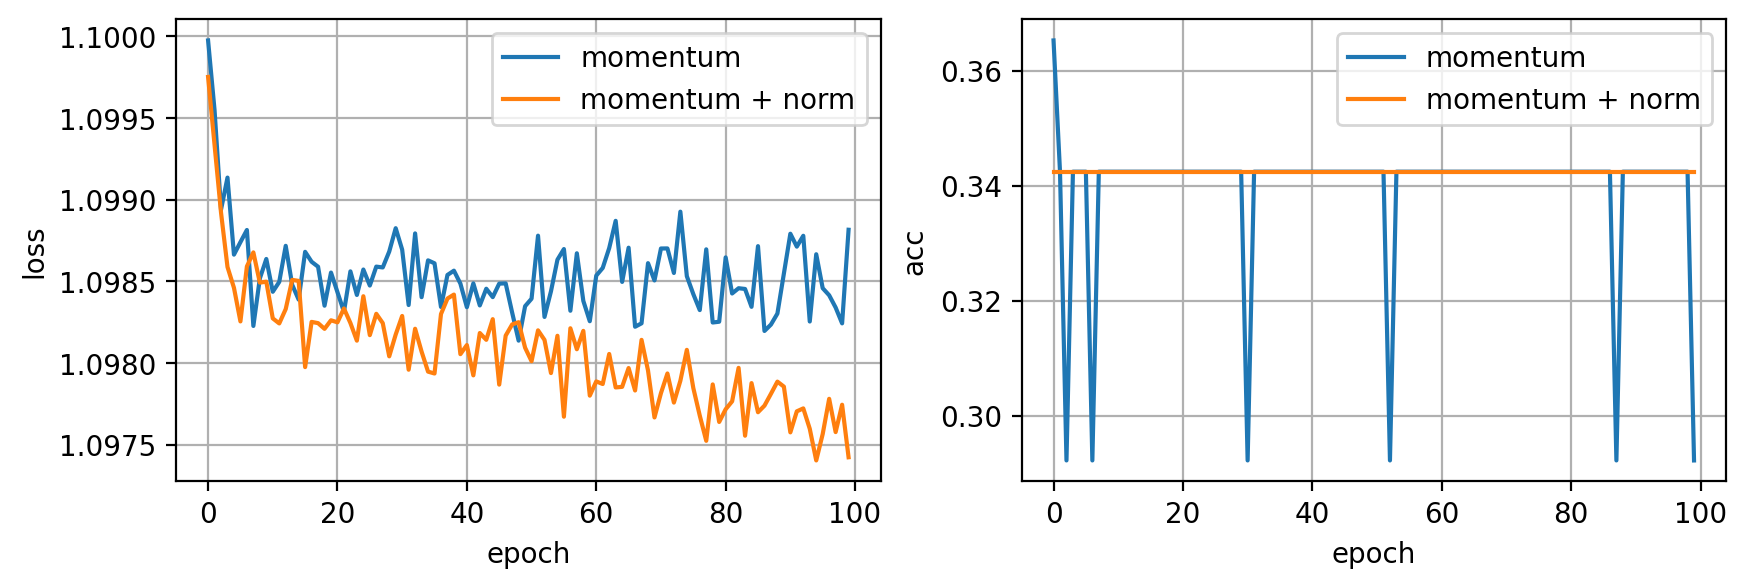

In [22]:
fig = plt.figure(dpi=200, figsize=(10,3))

ax = plt.subplot(121)
ax.plot(hist_momentum['loss'], label="momentum")
ax.plot(hist_norm['loss'], label="momentum + norm")
ax.legend()
ax.grid(True)
ax.set_xlabel('epoch')
ax.set_ylabel('loss')

ax = plt.subplot(122)
ax.plot(hist_momentum['val_acc'], label="momentum")
ax.plot(hist_norm['val_acc'], label="momentum + norm")
ax.legend()
ax.grid(True)
ax.set_ylabel('acc')
ax.set_xlabel('epoch')
plt.show()

In [23]:
def build_model(D_in=32*32*3, H=100, D_out=10):
    return torch.nn.Sequential(
        torch.nn.Linear(D_in, H),
        torch.nn.BatchNorm1d(H),
        torch.nn.ReLU(),
        torch.nn.Linear(H, H),
        torch.nn.BatchNorm1d(H),
        torch.nn.ReLU(),
        torch.nn.Linear(H, D_out)
    )

In [24]:
model = build_model()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
hist_bn = fit(model, dataloader, optimizer)

Mejor modelo guardado con acc 0.37671 en epoch 1
Mejor modelo guardado con acc 0.95890 en epoch 2
Mejor modelo guardado con acc 0.96804 en epoch 4
Mejor modelo guardado con acc 0.97717 en epoch 6
Mejor modelo guardado con acc 0.98174 en epoch 9
Epoch 10/100 loss 0.04369 acc 0.99716 val_loss 0.10580 val_acc 0.97032 lr 0.00100
Epoch 20/100 loss 0.01884 acc 0.99830 val_loss 0.06352 val_acc 0.97489 lr 0.00100
Mejor modelo guardado con acc 0.98402 en epoch 28
Epoch 30/100 loss 0.00827 acc 1.00000 val_loss 0.05081 val_acc 0.98402 lr 0.00100
Mejor modelo guardado con acc 0.98858 en epoch 37
Epoch 40/100 loss 0.00622 acc 0.99943 val_loss 0.06433 val_acc 0.97489 lr 0.00100
Epoch 50/100 loss 0.00412 acc 1.00000 val_loss 0.05718 val_acc 0.98402 lr 0.00100
Epoch 60/100 loss 0.00394 acc 1.00000 val_loss 0.06083 val_acc 0.97945 lr 0.00100
Epoch 70/100 loss 0.00278 acc 1.00000 val_loss 0.05614 val_acc 0.98174 lr 0.00100
Epoch 80/100 loss 0.00246 acc 1.00000 val_loss 0.06214 val_acc 0.97717 lr 0.00100

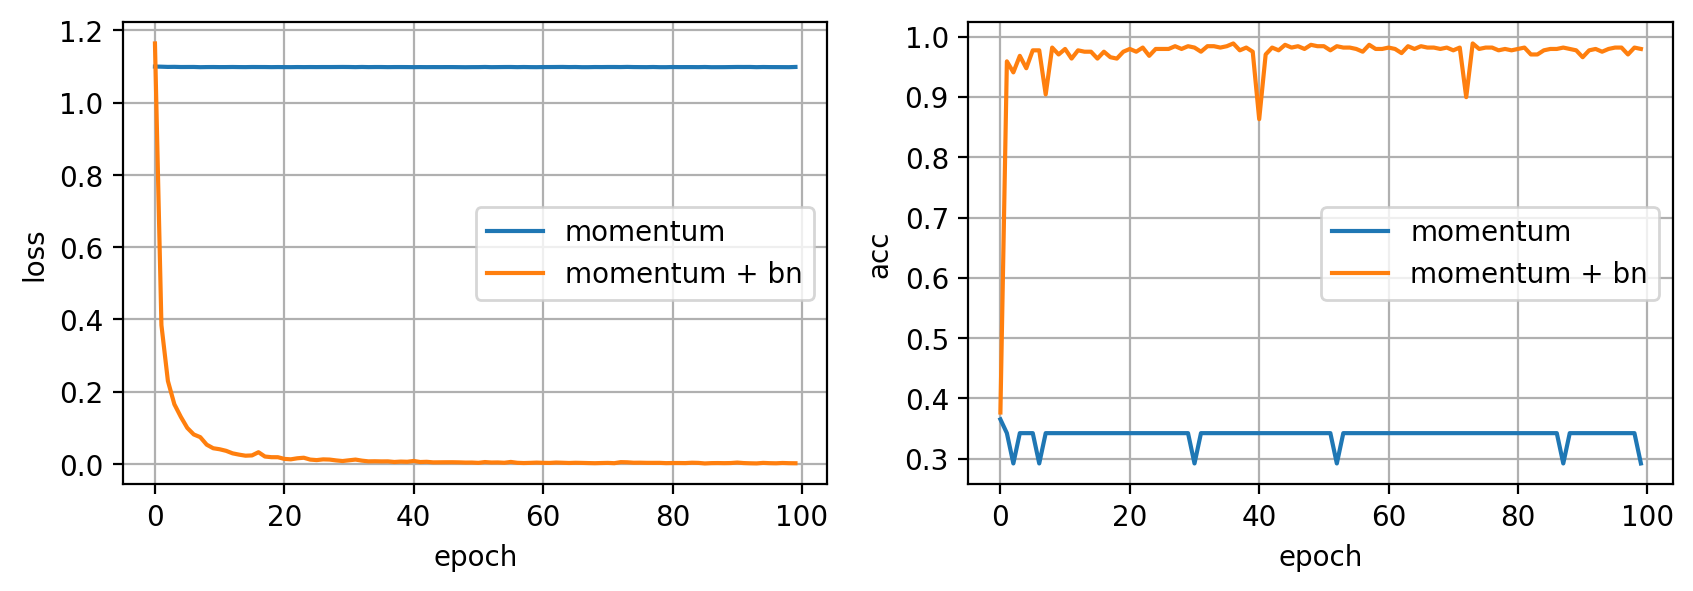

In [30]:
fig = plt.figure(dpi=200, figsize=(10,3))

ax = plt.subplot(121)
ax.plot(hist_momentum['loss'], label="momentum")
ax.plot(hist_bn['loss'], label="momentum + bn")
ax.legend()
ax.grid(True)
ax.set_xlabel('epoch')
ax.set_ylabel('loss')

ax = plt.subplot(122)
ax.plot(hist_momentum['val_acc'], label="momentum")
ax.plot(hist_bn['val_acc'], label="momentum + bn")
ax.legend()
ax.grid(True)
ax.set_ylabel('acc')
ax.set_xlabel('epoch')
plt.show()

In [26]:
def build_optimal_model(D_in=32*32*3, H=256, D_out=3):
    return torch.nn.Sequential(
        torch.nn.Linear(D_in, H),
        torch.nn.BatchNorm1d(H),
        torch.nn.ReLU(),
        torch.nn.Dropout(0.1),
        torch.nn.Linear(H, H//2),
        torch.nn.BatchNorm1d(H//2),
        torch.nn.ReLU(),
        torch.nn.Dropout(0.05),
        torch.nn.Linear(H//2, D_out)
    )

model_optimal = build_optimal_model()

optimizer_optimal = torch.optim.Adam(model_optimal.parameters(), lr=0.0001)

scheduler_optimal = torch.optim.lr_scheduler.StepLR(optimizer_optimal, step_size=50, gamma=0.9)

dataloader_optimal = {
    'train': torch.utils.data.DataLoader(dataset['train'], batch_size=64, shuffle=True),
    'val': torch.utils.data.DataLoader(dataset['val'], batch_size=1000, shuffle=False)
}

def fit_optimal(model, dataloader, optimizer, scheduler, epochs=80, log_each=10, early_stopping=20):
    criterion = torch.nn.CrossEntropyLoss()
    l, acc, lr = [], [], []
    val_l, val_acc = [], []
    best_acc, step = 0, 0
    
    for e in range(1, epochs+1):
        _l, _acc = [], []
        
        for param_group in optimizer.param_groups:
            lr.append(param_group['lr'])
            
        model.train()
        
        for x_b, y_b in dataloader['train']:
            y_pred = model(x_b)
            loss = criterion(y_pred, y_b)
            _l.append(loss.item())
            optimizer.zero_grad()
            loss.backward()
            
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            y_probas = torch.argmax(softmax(y_pred), axis=1)
            _acc.append(accuracy_score(y_b.cpu().numpy(), y_probas.cpu().detach().numpy()))
        
        l.append(np.mean(_l))
        acc.append(np.mean(_acc))
        
        model.eval()
        _l_val, _acc_val = [], []
        with torch.no_grad():
            for x_b, y_b in dataloader['val']:
                y_pred = model(x_b)
                loss = criterion(y_pred, y_b)
                _l_val.append(loss.item())
                y_probas = torch.argmax(softmax(y_pred), axis=1)
                _acc_val.append(accuracy_score(y_b.cpu().numpy(), y_probas.cpu().numpy()))
        
        val_l.append(np.mean(_l_val))
        val_acc.append(np.mean(_acc_val))
        
        if val_acc[-1] > best_acc:
            best_acc = val_acc[-1]
            torch.save(model.state_dict(), 'ckpt_optimal.pt')
            step = 0
            print(f"Mejor modelo guardado con acc {best_acc:.5f} en epoch {e}")
        step += 1
        
        if scheduler and e % 10 == 0:
            scheduler.step()
        
        if early_stopping and step > early_stopping:
            print(f"Entrenamiento detenido en epoch {e} por no mejorar en {early_stopping} epochs seguidas")
            break
            
        if not e % log_each:
            print(f"Epoch {e}/{epochs} loss {l[-1]:.5f} acc {acc[-1]:.5f} val_loss {val_l[-1]:.5f} val_acc {val_acc[-1]:.5f} lr {lr[-1]:.6f}")
    
    try:
        model.load_state_dict(torch.load('ckpt_optimal.pt'))
        print("Mejor modelo cargado exitosamente")
    except FileNotFoundError:
        print("No se guardó ningún modelo mejorado")
    
    return {
        'epoch': list(range(1, len(l)+1)), 
        'loss': l, 
        'acc': acc, 
        'val_loss': val_l, 
        'val_acc': val_acc, 
        'lr': lr
    }

hist_optimal = fit_optimal(model_optimal, dataloader_optimal, optimizer_optimal, scheduler_optimal)

Mejor modelo guardado con acc 0.29224 en epoch 1
Mejor modelo guardado con acc 0.92694 en epoch 3
Mejor modelo guardado con acc 0.93151 en epoch 5
Mejor modelo guardado con acc 0.94064 en epoch 7
Mejor modelo guardado con acc 0.96119 en epoch 8
Epoch 10/80 loss 0.04034 acc 0.99721 val_loss 0.44732 val_acc 0.78995 lr 0.000100
Mejor modelo guardado con acc 0.98174 en epoch 14
Epoch 20/80 loss 0.01005 acc 1.00000 val_loss 0.06782 val_acc 0.97945 lr 0.000100
Mejor modelo guardado con acc 0.98402 en epoch 21
Mejor modelo guardado con acc 0.98630 en epoch 22
Epoch 30/80 loss 0.00577 acc 1.00000 val_loss 0.09357 val_acc 0.96347 lr 0.000100
Epoch 40/80 loss 0.00435 acc 1.00000 val_loss 0.08484 val_acc 0.97945 lr 0.000100
Entrenamiento detenido en epoch 42 por no mejorar en 20 epochs seguidas
Mejor modelo cargado exitosamente


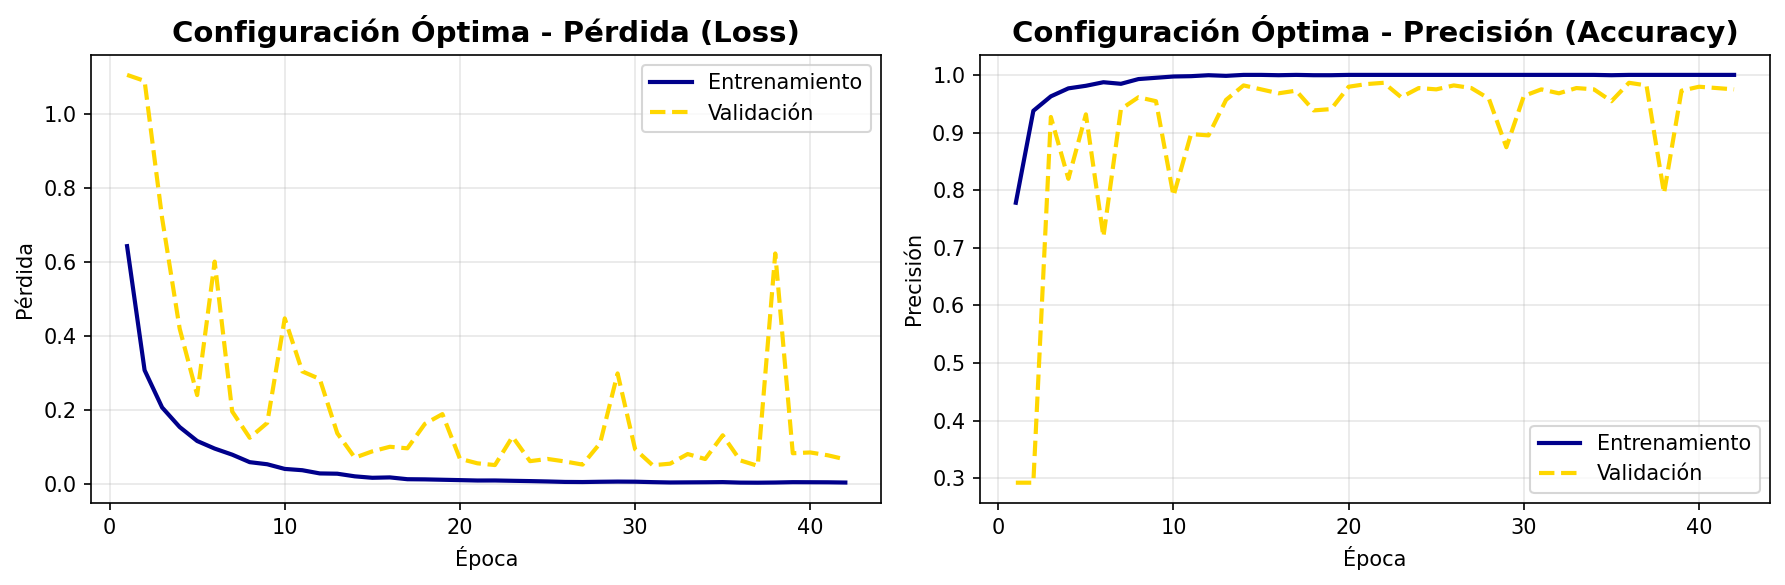

Configuración Óptima - Precisión final: 97.49%
Configuración Óptima - Mejor precisión alcanzada: 98.63%
Configuración Óptima - Épocas entrenadas: 42


In [27]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4), dpi=150)

ax1.plot(hist_optimal['epoch'], hist_optimal['loss'], 'darkblue', linewidth=2, label='Entrenamiento')
ax1.plot(hist_optimal['epoch'], hist_optimal['val_loss'], 'gold', linestyle='--', linewidth=2, label='Validación')
ax1.set_title('Configuración Óptima - Pérdida (Loss)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Época')
ax1.set_ylabel('Pérdida')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.plot(hist_optimal['epoch'], hist_optimal['acc'], 'darkblue', linewidth=2, label='Entrenamiento')
ax2.plot(hist_optimal['epoch'], hist_optimal['val_acc'], 'gold', linestyle='--', linewidth=2, label='Validación')
ax2.set_title('Configuración Óptima - Precisión (Accuracy)', fontsize=14, fontweight='bold')
ax2.set_xlabel('Época')
ax2.set_ylabel('Precisión')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

final_acc = hist_optimal['val_acc'][-1]
best_acc = max(hist_optimal['val_acc'])
print(f"Configuración Óptima - Precisión final: {final_acc:.2%}")
print(f"Configuración Óptima - Mejor precisión alcanzada: {best_acc:.2%}")
print(f"Configuración Óptima - Épocas entrenadas: {len(hist_optimal['epoch'])}")